In [1]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os

# Step 1 – Visualize IMU Signals (Optional but Recommended)

In [2]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

# Step 2 – Generate Inference Features

In [3]:
from extract_features import process_dataset
process_dataset('inference')

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|█████████████████████████████████████████████████████████████| 473/473 [00:04<00:00, 112.35it/s]


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,0.161736,2.400397,9.781118,-4.803209,14.584327,0.753975,2.075544,12,578.806370,-0.380257,...,20,75,507,S121701,v1.3.0,pending,39,6.984980,5g,model_a
1,0.060888,0.143728,0.281485,-0.210627,0.492113,-0.307806,-1.296353,17,2.436517,0.020410,...,13,47,140,S554373,v1.2.3,pending,43,8.559728,5g,model_a
2,1.420033,1.783070,8.587250,-4.277368,12.864617,0.187331,3.837204,23,519.583118,1.160100,...,20,44,201,S591907,v1.2.4,ok,88,8.112065,wifi,model_b
3,0.101729,0.272291,1.758731,-0.262157,2.020888,3.250768,15.145696,1,8.449124,0.018560,...,16,63,987,S766435,v1.3.0,recent,95,9.793977,5g,model_b
4,0.065654,0.147841,0.289539,-0.207996,0.497536,-0.365257,-1.277827,18,2.616736,0.017609,...,15,54,627,S574169,v1.3.0,pending,76,6.273467,5g,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.061702,0.147340,0.291371,-0.208436,0.499806,-0.407912,-1.211002,15,2.551629,0.015451,...,30,52,482,S223545,v1.2.3,recent,95,2.987759,4g,model_b
469,0.538580,1.726440,6.697460,-3.980186,10.677646,0.177812,2.211155,14,327.066508,1.449078,...,34,26,204,S692530,v1.2.3,recent,52,1.681527,5g,model_a
470,0.766066,2.672635,6.760884,-6.156577,12.917461,-0.036698,0.455227,14,772.983247,0.245231,...,32,59,698,S731085,v1.2.4,recent,69,8.076250,4g,model_b
471,0.117692,0.257051,1.816259,-0.218403,2.034662,3.585468,19.914983,2,7.992641,0.055911,...,32,35,942,S315872,v1.2.3,pending,64,6.159017,5g,model_b


# Step 3 – Load Labels for Inference Set

In [4]:
import pandas as pd
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

# Step 4 – Run Model Predictions

In [35]:
import joblib
from imu_pipeline import IMUPipeline

df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

inf_preds = model.predict(df_inf)
inf_probs = model.predict_proba(df_inf)

# Step 5 – Evaluate and Compare

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def model_scores(gt, pred):    
    # Evaluate inference set
    accuracy_inf = accuracy_score(gt, pred)
    precision_inf = precision_score(gt, pred, average='weighted')
    recall_inf = recall_score(gt, pred, average='weighted')
    f1_inf = f1_score(gt, pred, average='weighted')
    
    print("Inference Set Metrics:")
    print(f"Accuracy: {accuracy_inf:.4f}")
    print(f"Precision: {precision_inf:.4f}")
    print(f"Recall: {recall_inf:.4f}")
    print(f"F1 Score: {f1_inf:.4f}")
    print("\nClassification Report:\n", classification_report(gt, pred))

    ConfusionMatrixDisplay.from_predictions(gt, pred)
    plt.title('Test set - Confusion Matrix:')
    plt.show()

### Evaluate model on inference set

Inference Set Metrics:
Accuracy: 0.6448
Precision: 0.7384
Recall: 0.6448
F1 Score: 0.6066

Classification Report:
               precision    recall  f1-score   support

   collision       0.59      0.96      0.73       236
      normal       0.89      0.33      0.48       237

    accuracy                           0.64       473
   macro avg       0.74      0.65      0.61       473
weighted avg       0.74      0.64      0.61       473



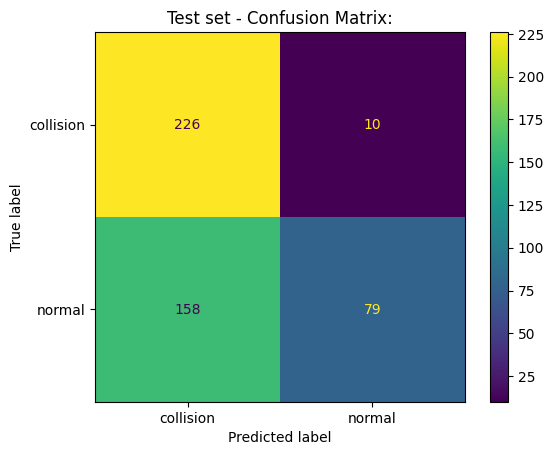

In [61]:
# Merge predictions with labels for comparison
compare_inf_preds_df = pd.DataFrame(inf_preds, columns=['pred'])
compare_inf_preds_df['sample_id'] = df_inf['sample_id'].values

merged_inf_df = compare_preds_df.merge(labels, on='sample_id', how='left')

model_scores(merged_inf_df['label'], merged_inf_df['pred'])

### Evaluate model on train set

Inference Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

   collision       1.00      1.00      1.00       400
      normal       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



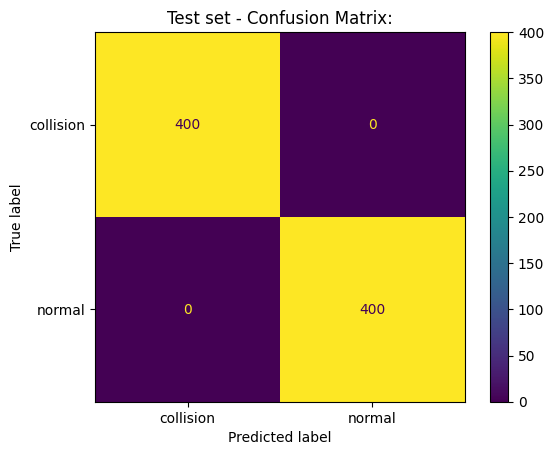

In [62]:
df_train = pd.read_csv("data/train.csv")

# Generate test set predictions
train_preds = model.predict(df_train)
train_probs = model.predict_proba(df_train)


model_scores(df_train['label'], train_preds)

### Evaluate model on test set

Inference Set Metrics:
Accuracy: 0.9450
Precision: 0.9505
Recall: 0.9450
F1 Score: 0.9448

Classification Report:
               precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



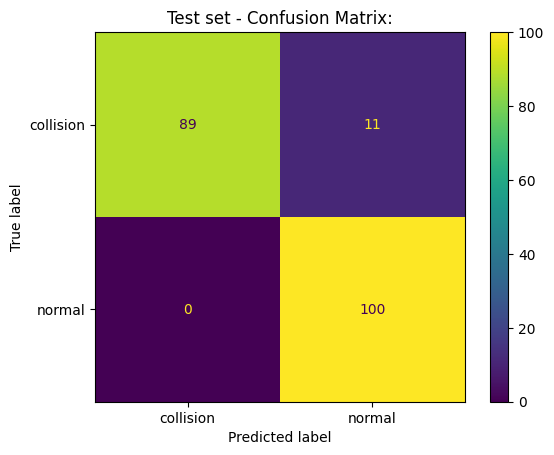

In [63]:
df_test = pd.read_csv("data/test.csv")

# Generate test set predictions
test_preds = model.predict(df_test)
test_probs = model.predict_proba(df_test)


model_scores(df_test['label'], test_preds)

### *Performance on the newer data severly degraded. Initial reaction is that perhaps model overfit on the data, seeing as the train set was 100% accurate and maybe the model with best performance on the test set was selected, meaning it doesn't generate well.*

### *However, data exploration must be performed on the underlying data to make sure the features come from similar distributions, otherwise even a well trained model would still fail and this may explain the behavior above*


# EDA

### Check label ratio

Target Distribution in Test Set:
label
normal       100
collision    100
Name: count, dtype: int64


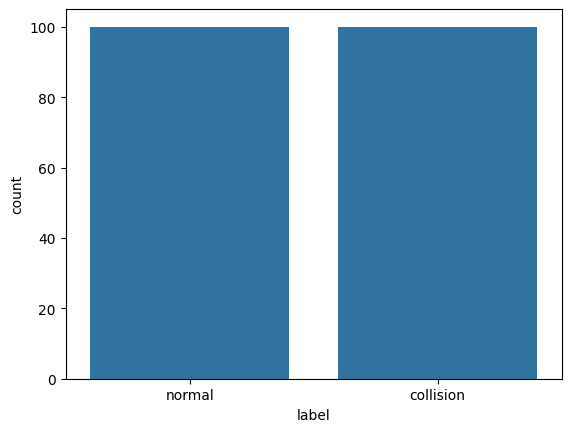

Target Distribution in Inference Set:
label
normal       237
collision    236
Name: count, dtype: int64


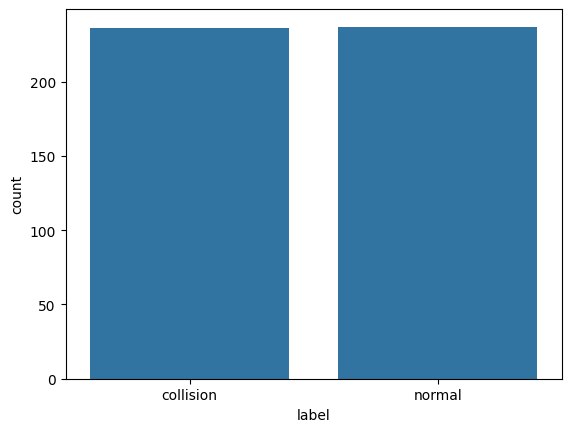

In [72]:
def target_analysis(df, target_col='target', name="Dataset"):
    if target_col in df.columns:
        print(f"Target Distribution in {name}:")
        print(df[target_col].value_counts())
        sns.countplot(x=target_col, data=df)
        plt.show()

target_analysis(df_test, target_col='label', name="Test Set")
target_analysis(merged_inf_df, target_col='label', name="Inference Set")

### *Equal Distributions in both Test and Inf set*

### Numerical analysis

In [94]:
import pandas as pd

def compare_descriptive_stats(df_test, df_inf):
    # restrict to numeric columns that exist in both
    num_cols = [col for col in df_test.select_dtypes(include=['int64','float64']).columns 
                if col in df_inf.columns]

    # describe both datasets
    desc_test = df_test[num_cols].describe().T
    desc_inf = df_inf[num_cols].describe().T

    # add suffix to differentiate
    desc_test = desc_test.add_suffix('_test')
    desc_inf = desc_inf.add_suffix('_inf')

    # merge side by side
    comparison = pd.concat([desc_test, desc_inf], axis=1)

    # sort columns alphabetically
    comparison = comparison[sorted(comparison.columns)]

    return comparison

# Usage
stats_comparison = compare_descriptive_stats(df_test, df_inf)
pd.set_option("display.float_format", "{:.3f}".format) 

# Optional: widen display for long tables
pd.set_option('display.width', 150)
print(stats_comparison)


                     25%_inf  25%_test  50%_inf  50%_test   75%_inf  75%_test  count_inf  count_test   max_inf  max_test  mean_inf  mean_test  \
x_mean                 0.058     0.061    0.071     0.064     0.790     0.087    473.000     200.000     3.307     0.116     0.334      0.072   
x_std                  0.149     0.143    1.852     0.146     2.261     0.213    473.000     200.000     3.362     0.329     1.473      0.176   
x_max                  0.308     0.273    6.048     0.288     8.347     1.222    473.000     200.000    20.341     2.217     5.338      0.664   
x_min                 -7.434    -0.230   -4.760    -0.219    -0.228    -0.211    473.000     200.000    -0.183    -0.183    -4.532     -0.220   
x_range                0.543     0.490   12.216     0.508    15.151     1.434    473.000     200.000    28.704     2.449     9.870      0.885   
x_skew                -0.393    -0.391   -0.132    -0.352     0.404     1.926    473.000     200.000     3.816     4.163     0.156

### *No missing values, but Inf mean is way off from Test mean for signals X and Y*

### Visual analysis

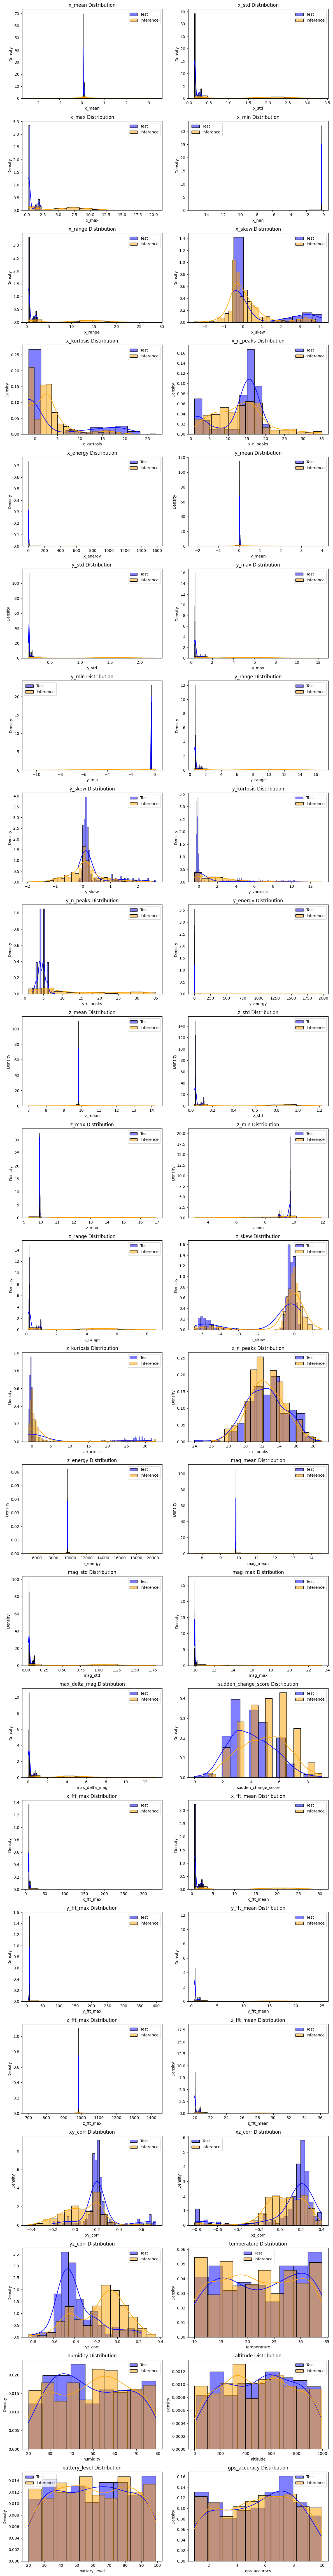

In [73]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

def compare_numerical_distributions(df_test, df_inf, n_cols_per_row=2):
    num_cols = df_test.select_dtypes(include=['int64', 'float64']).columns
    n_cols = len(num_cols)
    n_rows = math.ceil(n_cols / n_cols_per_row)

    fig, axes = plt.subplots(n_rows, n_cols_per_row, figsize=(6*n_cols_per_row, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.histplot(df_test[col], kde=True, color='blue', label='Test', ax=axes[i], stat="density", alpha=0.5)
        sns.histplot(df_inf[col], kde=True, color='orange', label='Inference', ax=axes[i], stat="density", alpha=0.5)
        axes[i].set_title(f"{col} Distribution")
        axes[i].legend()

    # Remove empty subplots if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Usage
compare_numerical_distributions(df_test, df_inf, n_cols_per_row=2)

### *large differences in signal data*

### Compare Categorical Distributions

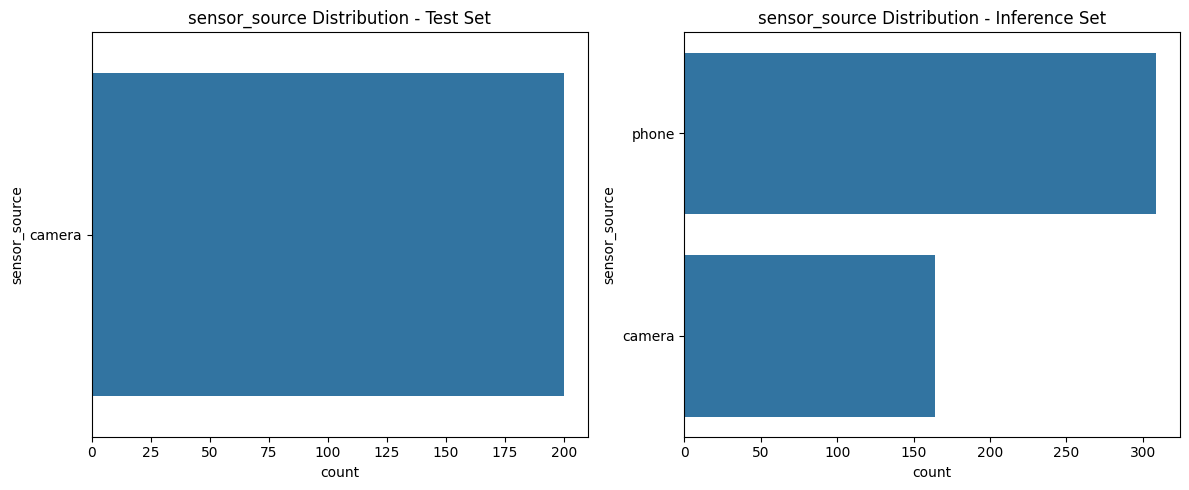

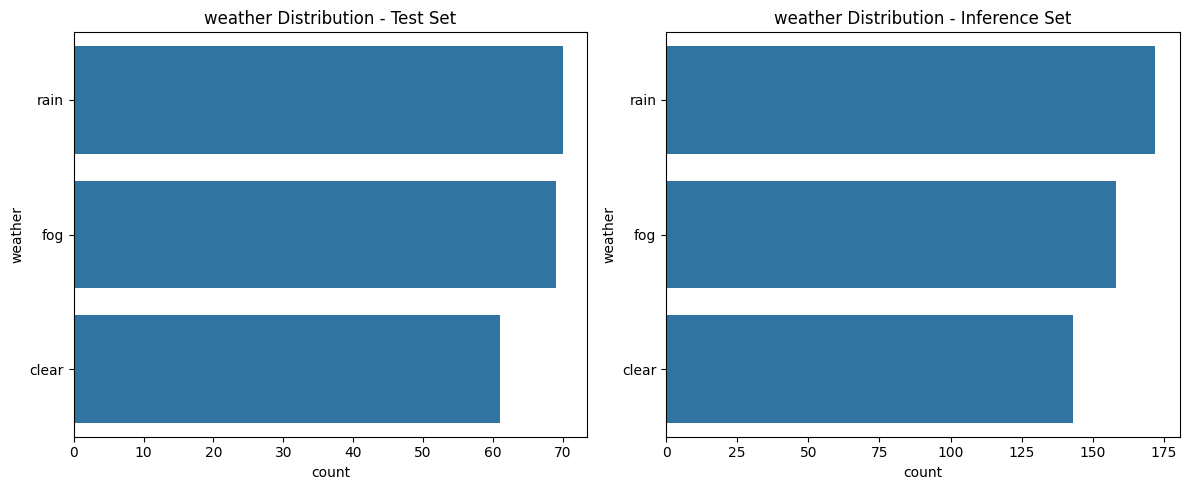

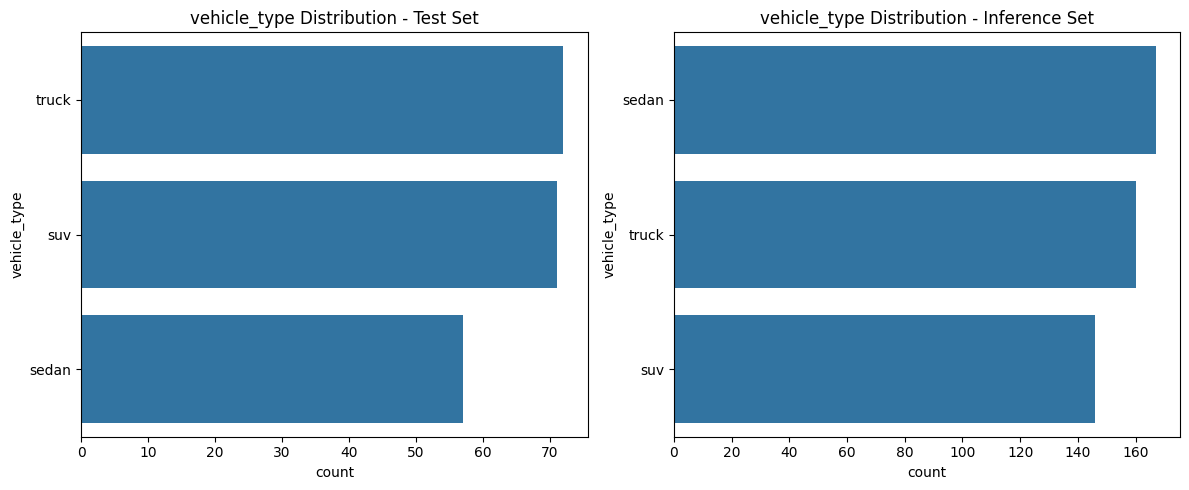

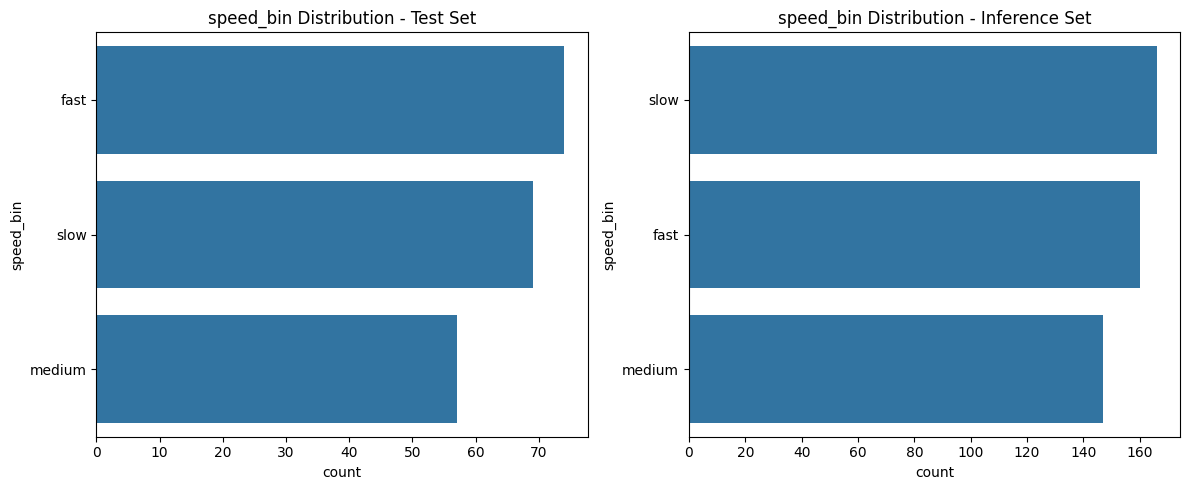

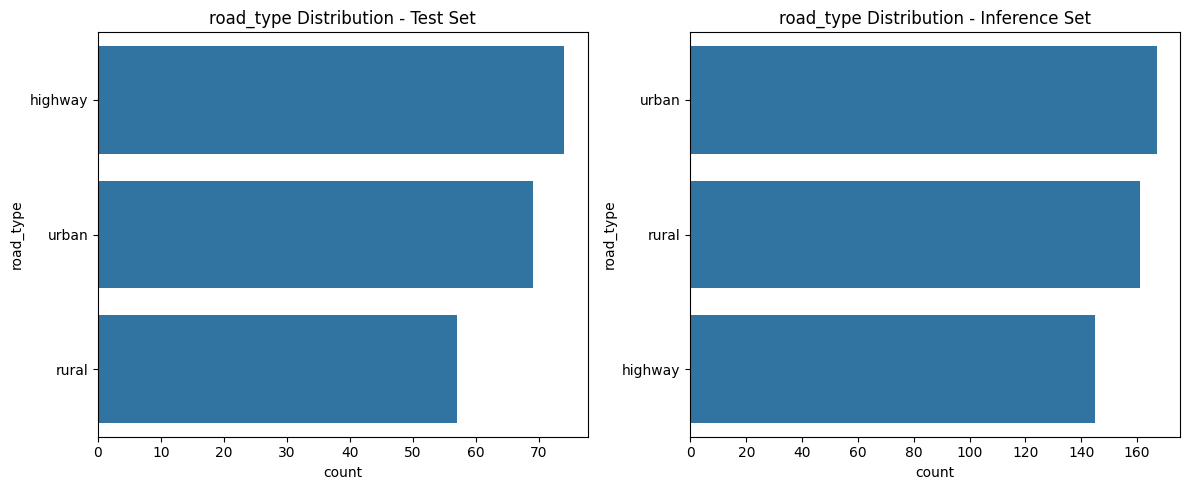

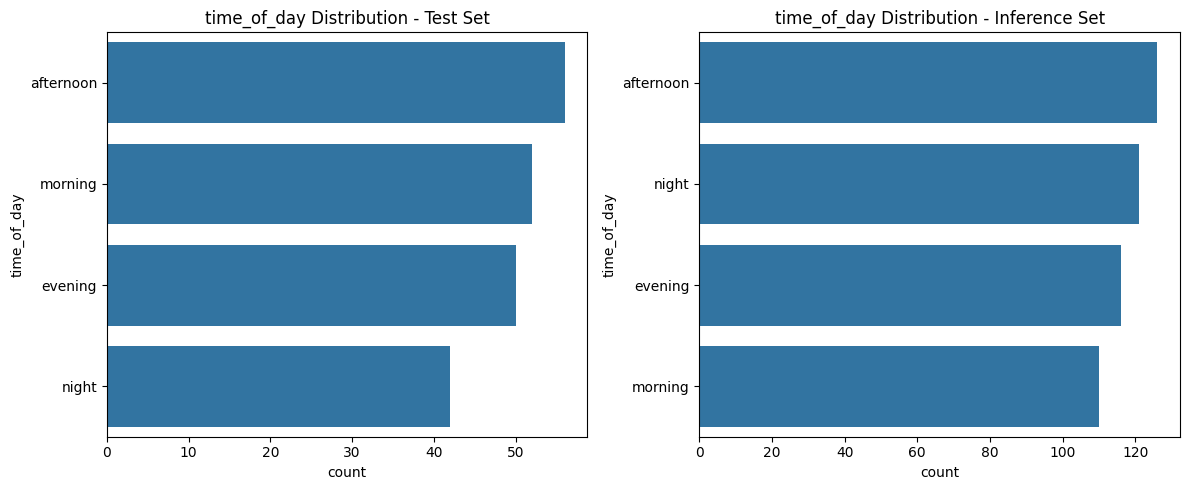

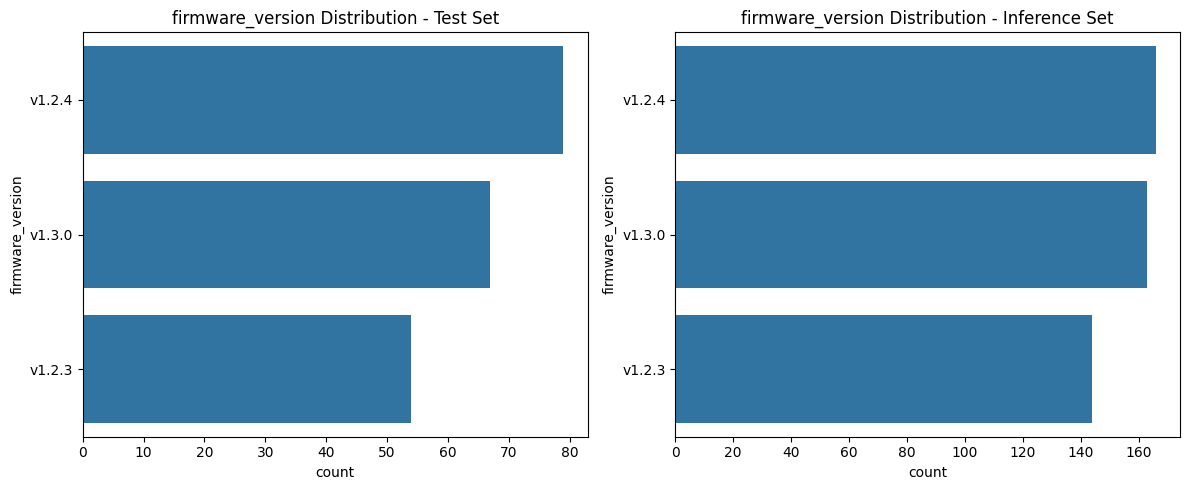

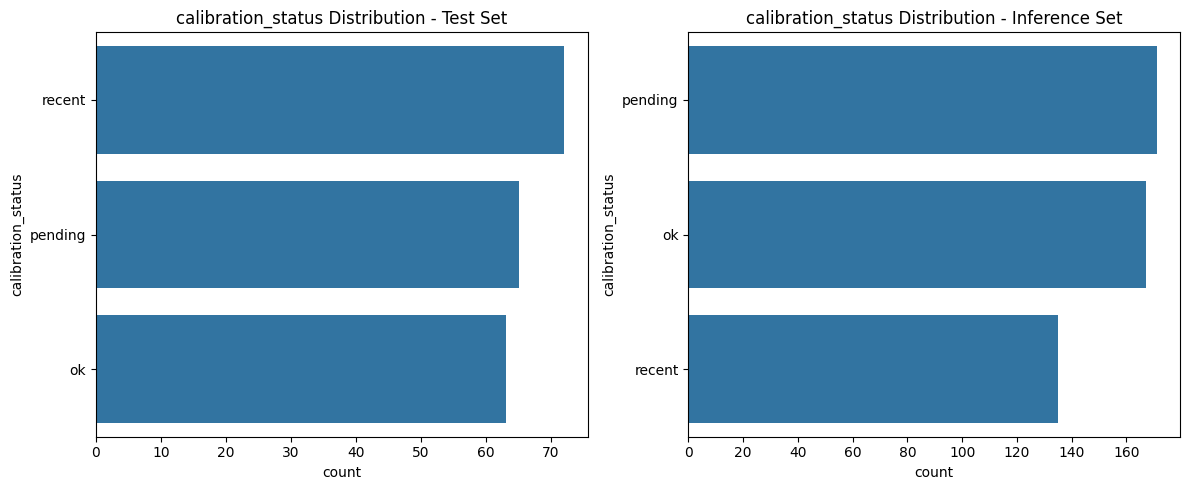

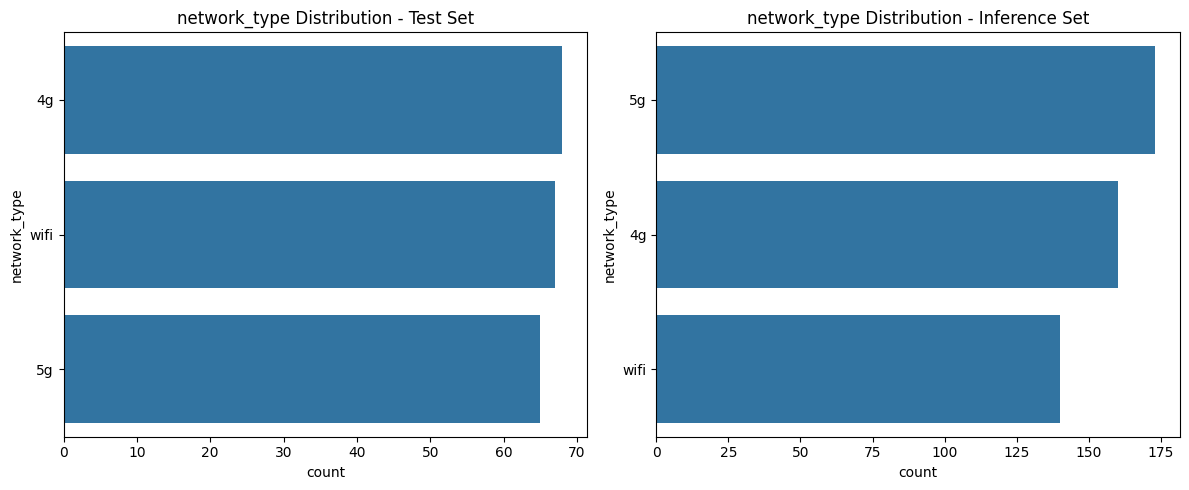

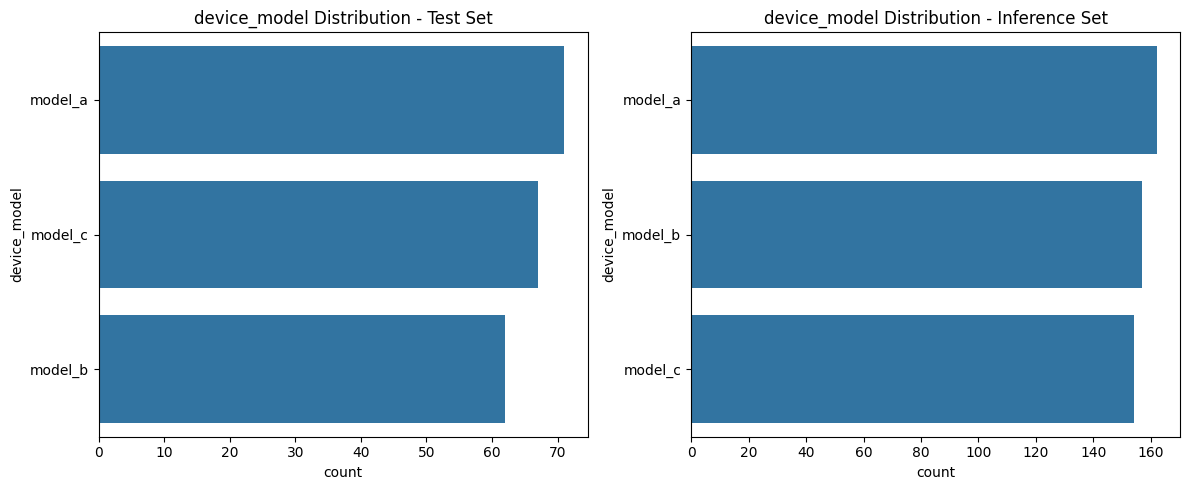

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_categorical_distributions(df_test, df_inf, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = ['sample_id', 'driver_id', 'timestamp', 'session_id']

    # get categorical columns (excluding IDs)
    cat_cols = [col for col in df_test.select_dtypes(include=['object','category']).columns
                if col not in exclude_cols and col in df_inf.columns]

    for col in cat_cols:
        plt.figure(figsize=(12,5))

        # Test set distribution
        plt.subplot(1,2,1)
        sns.countplot(y=col, data=df_test, order=df_test[col].value_counts().index)
        plt.title(f"{col} Distribution - Test Set")

        # Inference set distribution
        plt.subplot(1,2,2)
        sns.countplot(y=col, data=df_inf, order=df_inf[col].value_counts().index)
        plt.title(f"{col} Distribution - Inference Set")

        plt.tight_layout()
        plt.show()

# Usage
compare_categorical_distributions(df_test, df_inf)



### *Test Set only contains Camera Sensor DAta, not phone data. This may explain the discrepancy*

In [98]:
# Filter inference set for only rows with sensor_type == "camera"
df_inf_camera = df_inf[df_inf['sensor_source'] == 'camera']

# Run predictions only on this subset
inf_preds_camera = model.predict(df_inf_camera)

print(inf_preds_camera[:10])  # preview
print("Total predictions for camera rows:", len(inf_preds_camera))

['normal' 'collision' 'normal' 'normal' 'collision' 'normal' 'normal'
 'collision' 'collision' 'collision']
Total predictions for camera rows: 164


Inference Set Metrics:
Accuracy: 0.9390
Precision: 0.9459
Recall: 0.9390
F1 Score: 0.9389

Classification Report:
               precision    recall  f1-score   support

   collision       1.00      0.88      0.94        85
      normal       0.89      1.00      0.94        79

    accuracy                           0.94       164
   macro avg       0.94      0.94      0.94       164
weighted avg       0.95      0.94      0.94       164



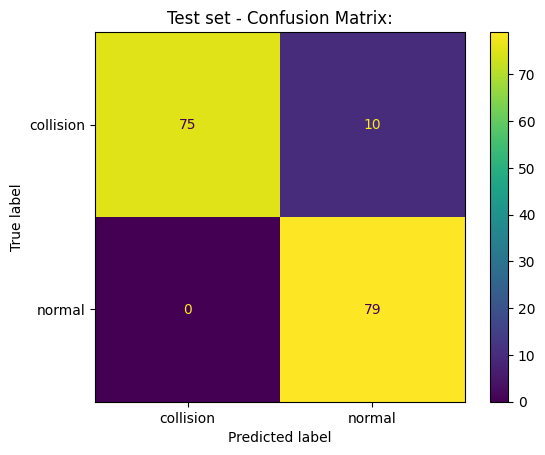

In [100]:
# Merge predictions with labels for comparison
compare_inf_preds_camera = pd.DataFrame(inf_preds_camera, columns=['pred'])
compare_inf_preds_camera['sample_id'] = df_inf_camera['sample_id'].values

merged_inf_preds_camera = compare_inf_preds_camera.merge(labels, on='sample_id', how='left')
merged_inf_preds_camera
model_scores(merged_inf_preds_camera['label'], merged_inf_preds_camera['pred'])

### *Does much better now without phone data*
### *Can we pinpoint the cause further?*

### Analyze inf phone set vs. inf camera set

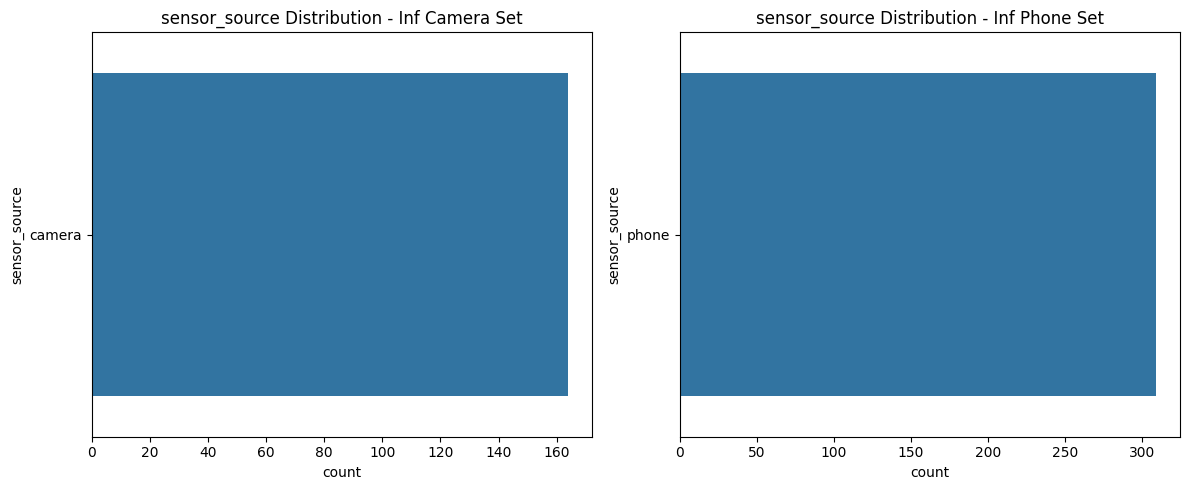

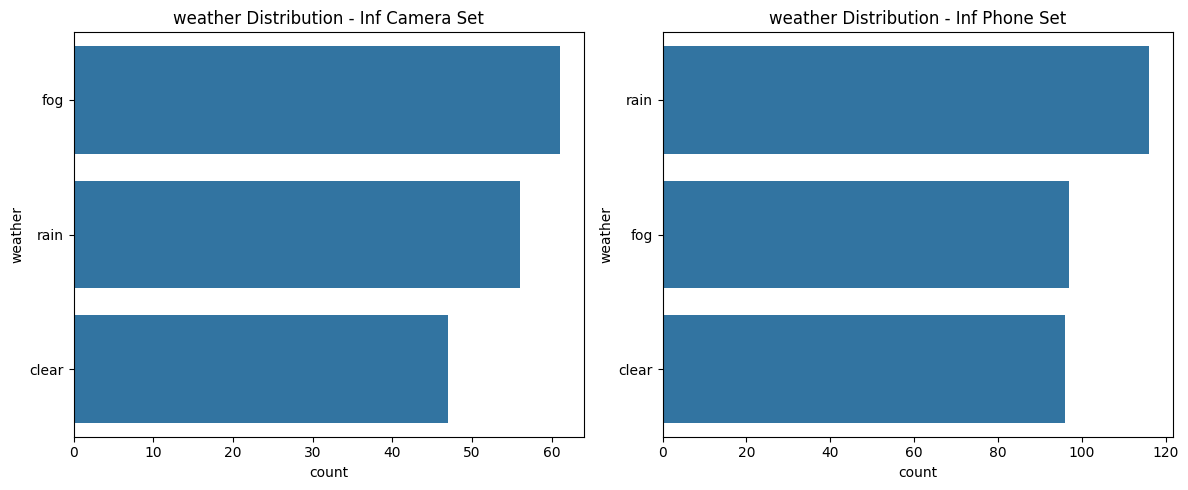

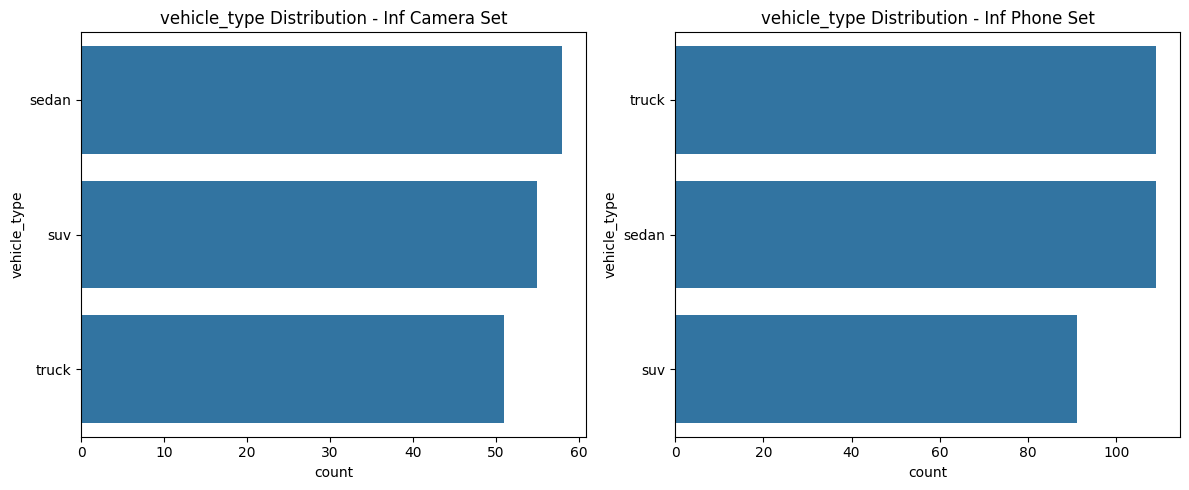

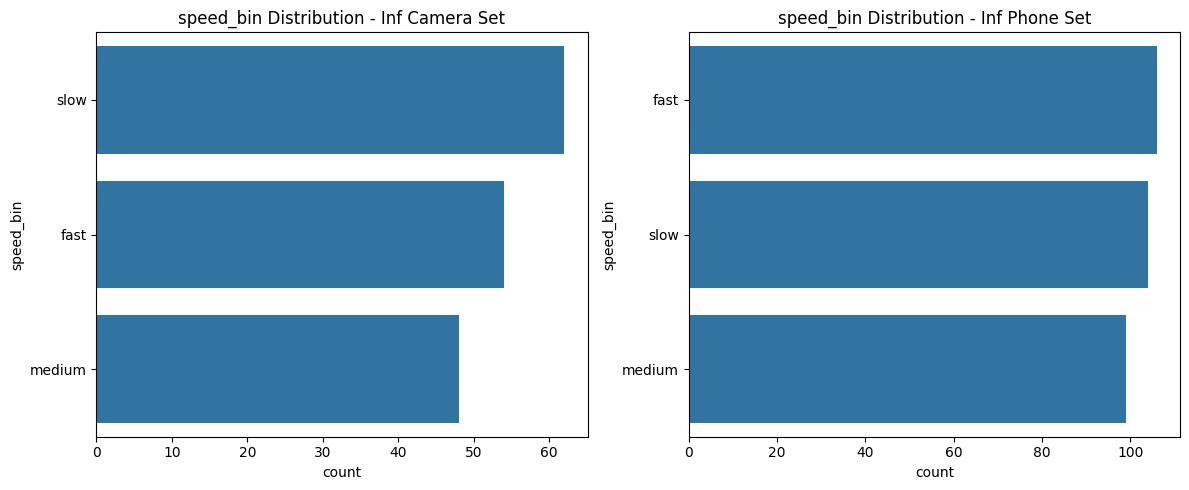

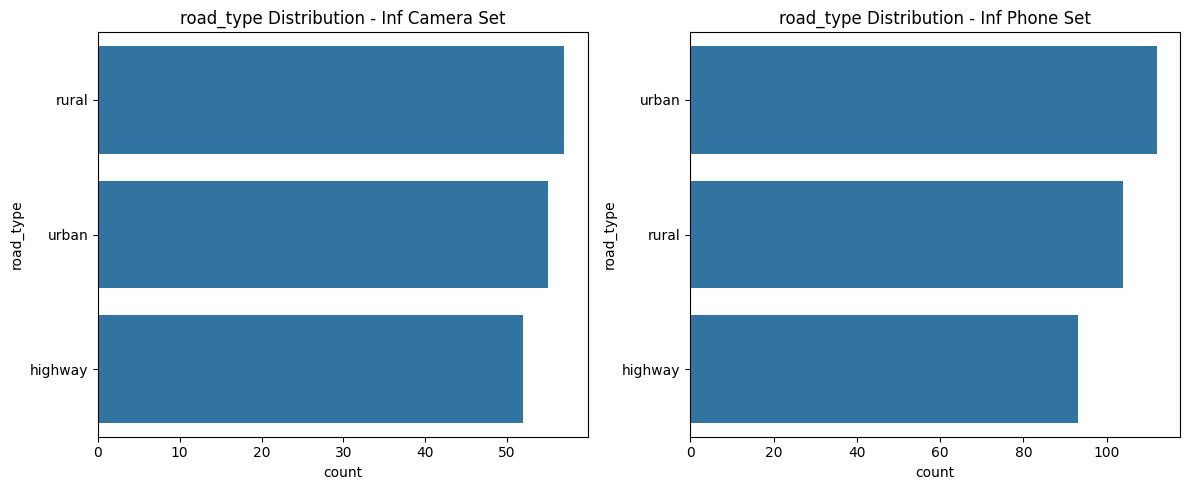

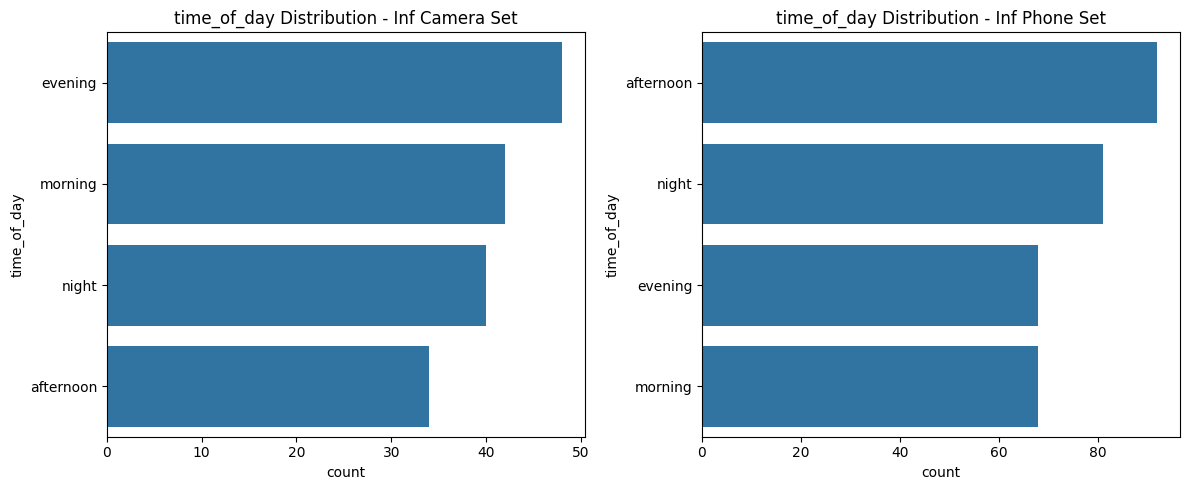

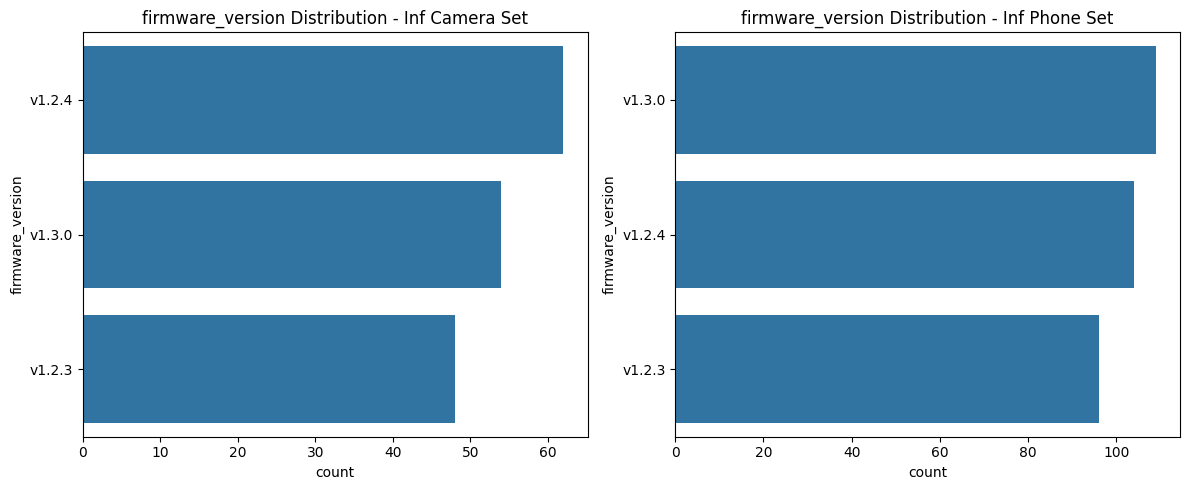

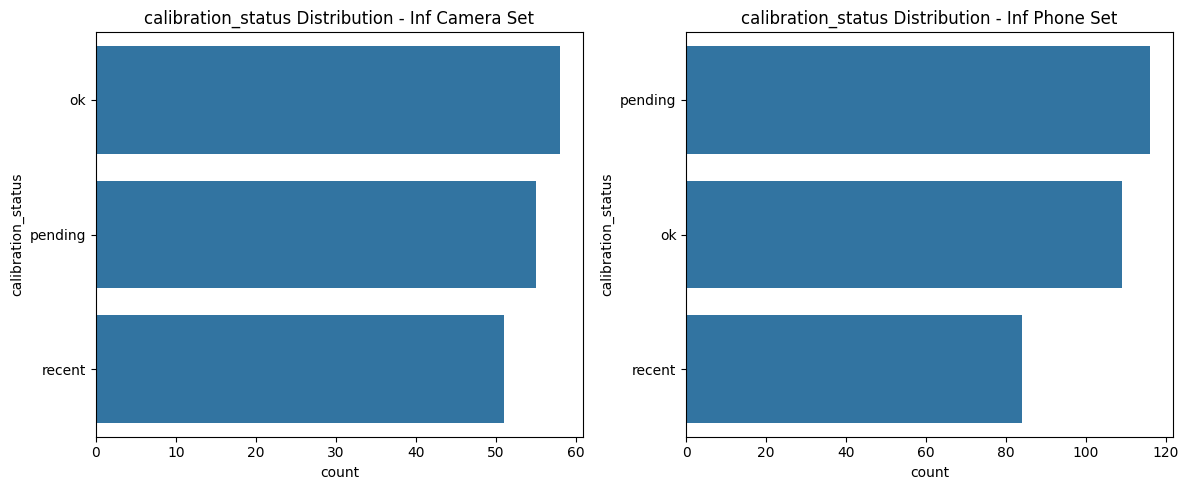

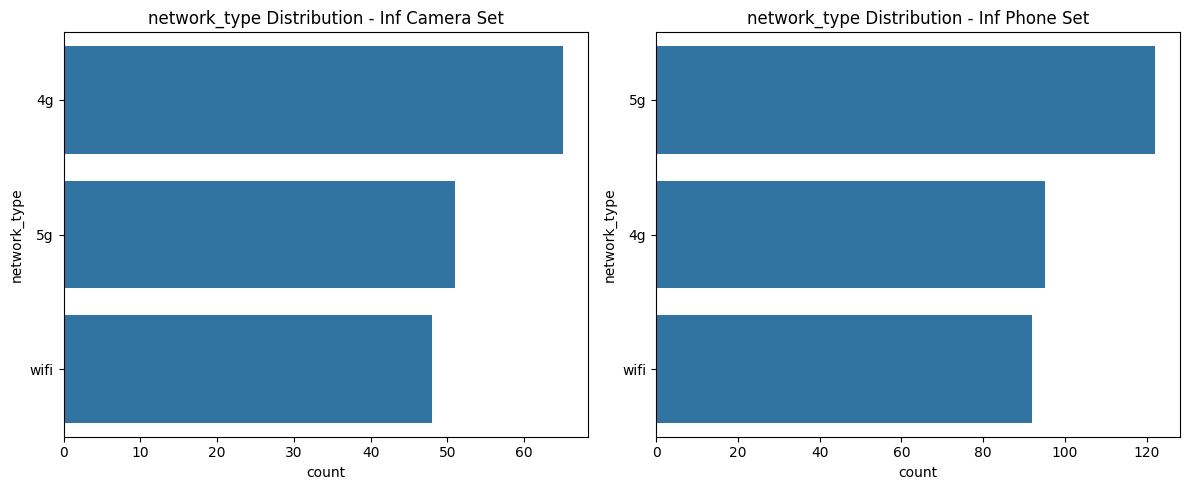

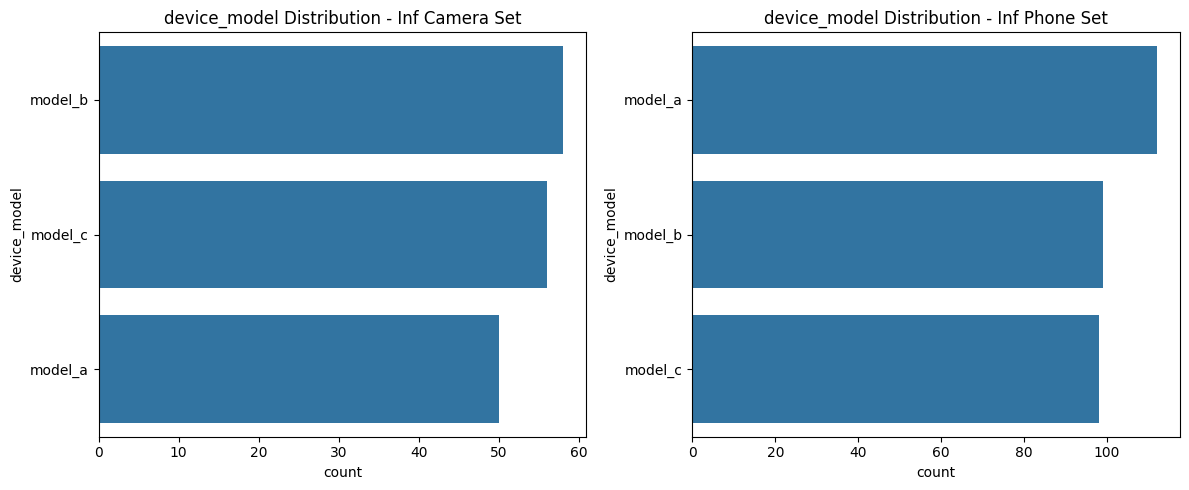

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_categorical_distributions(df_test, df_inf, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = ['sample_id', 'driver_id', 'timestamp', 'session_id']

    # get categorical columns (excluding IDs)
    cat_cols = [col for col in df_test.select_dtypes(include=['object','category']).columns
                if col not in exclude_cols and col in df_inf.columns]

    for col in cat_cols:
        plt.figure(figsize=(12,5))

        # Test set distribution
        plt.subplot(1,2,1)
        sns.countplot(y=col, data=df_test, order=df_test[col].value_counts().index)
        plt.title(f"{col} Distribution - Inf Camera Set")

        # Inference set distribution
        plt.subplot(1,2,2)
        sns.countplot(y=col, data=df_inf, order=df_inf[col].value_counts().index)
        plt.title(f"{col} Distribution - Inf Phone Set")

        plt.tight_layout()
        plt.show()

# Usage
df_inf_camera = df_inf[df_inf['sensor_source'] == 'camera']
df_inf_phone = df_inf[df_inf['sensor_source'] == 'phone']
compare_categorical_distributions(df_inf_camera, df_inf_phone)

### *Nothing immediately pops out*

# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

#### Performance on the newer data severly degraded. Initial reaction is that perhaps model overfit on the data, seeing as the train set was 100% accurate and maybe the model with best performance on the test set was selected, meaning it doesn't generate well.

#### However, data exploration must be performed on the underlying data to make sure the features come from similar distributions, otherwise even a well trained model would still fail and this may explain the behavior above

- Is there anything in the data that might explain differences in behavior?

#### The test and train set used only camera data, not phone data

- Can you identify patterns or trends related to when the model succeeds or fails?

#### When using only camera data of the Inf set it does much better

- Are there signals or features that seem to affect the model’s reliability?

#### The distributions of the x,y,z signals are very different, in Inf set they are way more widely spread out. These outliers and out of distribution values cause the model to when generalizing to this unseen data

- What could be done in the short term to handle the current situation?

#### A short term fix would be to simply drop phone data. 
#### Alternatively, it may be that the incoming data wasn't normalized properly and that the camera and phone distributions would have similar behavior if only the data was whitened beforehand. Therefore, it is important to verify this.
#### We can also simply retrain the model by with more phone data to see if it can handle the widespread distribution.

- What are potential long-term steps to improve model performance in similar scenarios?

#### Long term we don't want to simply drop phone data so we want to check if there is a calibration error or a firmware error when deployed on phone.
#### We would also want to simplify the data and drop features by verifying that all of these signals are actually correlated to the data, since many of them seem redundant and are features that the model itself will pick up on.

- What would you want to explore further if given more time or data?

#### I'd want to check which signal x,y,z is most affected by the discrepancy in sensor source. I'd want to check whether the x,y,z signals are just garbage or if there is some underlying common pattern with signals from camera such that with some transformation we can reach the same distribution as the camera sensors. This transformation would assist with calibrating the phone sensors.

- What assumptions did the model rely on during training — and are they still valid?
#### If it didn't normalize the data properly then it assumed that future phone information would be on the same magnitdue. In fact it also assumes that the camera data was configured properly too. Perhaps it is the phone data that is correct and the camera data that is not and the model overtrained on the data. Though it is unlikely that the camera data is complete garbage otherwise the model would not have generalized as well to the train set